In [2]:
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


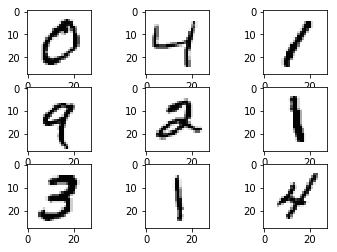

In [15]:
### PRE-PROCESSING

## Import the data 
from keras.datasets import mnist
(x_train, Y_train), (xtest, Ytest) = mnist.load_data()

## Create training and validation set
xtrain=x_train[:int(0.8*len(x_train)),:,:]
Ytrain=Y_train[:int(0.8*len(x_train))]
xval=x_train[int(0.8*len(x_train)):,:,:]
Yval=Y_train[int(0.8*len(x_train)):]

## Normalization
xtrain = xtrain/255
xval = xval/255
xtest = xtest/255

## Example of images
for t in range(1,10):
    plt.subplot(330+t)
    plt.imshow(xtrain[t],cmap='Greys')
plt.show()

## Reshape the data
xtrain=np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2],1))
xval=np.reshape(xval,(xval.shape[0],xval.shape[1],xval.shape[2],1))
xtest=np.reshape(xtest,(xtest.shape[0],xtest.shape[1],xtest.shape[2],1))

## One-hot encoding the labels
from keras.utils.np_utils import to_categorical
ytrain = to_categorical(Ytrain)
yval = to_categorical(Yval)
ytest = to_categorical(Ytest)

In [41]:
### MODEL GENERATION

## Hyperparameter generation

# makeHyper generates a set of hyperparameters:
# During the optimization process all the hyperparameters are normalized to range between 0 and 1
# makeHyper makes the transformation between 0 and 1 and the actuel hyperparameter space:
    # l2reg ranges in [1,1e-10] (float)
    # dropout ranges in [0,1] (float)
    # batchsize ranges in [1,100] (integer)
    
def makeHyper(hyper):
        
    l2reg = np.power(10,-10*hyper[0])
    dropout = hyper[1]
    batchsize = 1+int(99*hyper[2])
    
    return([l2reg,dropout,batchsize])

## Model generation

# createModel creates a LeNet1-model given an array 'hyper'
# 'hyper' is an array of normalized hyperparameters (float in [0,1])

import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

def createModel(hyper):
        
    [l2reg,dropout,batchsize]=makeHyper(hyper) # makes the transformation between [0,1] and the actuel hyperparameter space
    
    model = Sequential()

    model.add(Conv2D(4, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(12, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax',kernel_regularizer=keras.regularizers.l2(l2reg)))
    
    return(model)

In [45]:
### MODEL EVALUATION
def objective(hyper):
    
    model = createModel(hyper)
    model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    cb = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]   
    
    [l2reg,dropout,batchsize]=makeHyper(hyper)
    print('l2reg = '+str(l2reg)+' | dropout = '+str(dropout)+' | batchsize = '+str(batchsize))
    
    model.fit(xtrain ,ytrain, batch_size = batchsize,epochs = 200, validation_data=(xval,yval),verbose=0,callbacks=cb)
    score = 100-100*model.evaluate(xtest,ytest,verbose=0)[1]
    print('error rate (%) = '+str(score))
    print('---------------------------------------------------------')
      
    return score

def objective_vec(hyper_vec,n):
    
    res_vec=np.zeros((n,1))
    for i in range(n):
        res_vec[i]=objective(hyper_vec[i,:])
        
    return(res_vec)

In [46]:
### SWARM DEFINITION

## Swarm Initialization
# the position and the velocity of n particles in the d dimensional space are initialized randomly
def initializeSwarm(n,d,hist):
    
    position=np.random.rand(n,d)
    velocity=np.random.rand(n,d)-0.5
    
    position_pbest=np.copy(position)  
    value_pbest=objective_vec(position_pbest,n)
    
    position_gbest=position[value_pbest.argmax(axis=0),:]
    value_gbest=value_pbest[value_pbest.argmax(axis=0),:]
    
    for i in range(n):
        hist.append([i,np.copy(position_pbest[i,:]),float(np.copy(value_pbest[i])),np.copy(position_pbest[i,:]),float(np.copy(value_pbest[i])),np.copy(position_gbest),float(np.copy(value_gbest)),np.copy(velocity[i,:])])
 
    return position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,hist

## Swarm Definition
# the n particles move in the search space according to the Swarm update formulas
def evolutionSwarm(n,position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,omega,c1,c2,hist):
    for i in range(n):
        #print('###')
        #print('particle '+str(i))
        #print('previous position : '+str(position[i]))
        r1=np.random.rand()
        r2=np.random.rand()
        velocity[i,:]=omega*velocity[i,:]+c1*r1*(position_pbest[i,:]-position[i,:])+c2*r2*(position_gbest-position[i,:])
        position[i,:]=position[i,:]+velocity[i,:]
        position=np.clip(position,0,1)
        #print('new position : '+str(position[i]))
        value=objective(position[i,:])
        #print(value)
        if value>value_pbest[i]:
            #print('new personal best')
            position_pbest[i]=position[i]
            value_pbest[i]=value
            if value>value_gbest:
                position_gbest=position[i]
                value_gbest=value
                print('### new global best: '+str(value_gbest)+' ###')
                print('---------------------------------------------------------')
        hist.append([i,np.copy(position[i,:]),float(np.copy(value)),np.copy(position_pbest[i,:]),float(np.copy(value_pbest[i])),np.copy(position_gbest),float(np.copy(value_gbest)),np.copy(velocity[i,:])])        
    #print('--- global best = '+str(position_gbest))
    return position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,hist

In [47]:
### SWARM OPTIMIZATION

n=5
d=3
omega=0.5
c1=0.5
c2=0.5

P=[]
hist=[]
# Initialization
np.random.seed(4)
position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,hist=initializeSwarm(n,d,hist)
P.append(np.copy(position))

for t in range(15):
    
    #print('===================== new iteration ======================')

    position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,hist=evolutionSwarm(n,position,velocity,position_pbest,value_pbest,position_gbest,value_gbest,omega,c1,c2,hist)
    P.append(np.copy(position))

l2reg = 2.1364936672210119e-10 | dropout = 0.5472322491757223 | batchsize = 97
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
 - 4s - loss: 1.9646 - acc: 0.3956 - val_loss: 1.3598 - val_acc: 0.7205
Epoch 2/200
 - 4s - loss: 1.0928 - acc: 0.6880 - val_loss: 0.7143 - val_acc: 0.8367
Epoch 3/200
 - 3s - loss: 0.7750 - acc: 0.7657 - val_loss: 0.5440 - val_acc: 0.8624
Epoch 4/200
 - 4s - loss: 0.6638 - acc: 0.7974 - val_loss: 0.4707 - val_acc: 0.8743
Epoch 5/200
 - 4s - loss: 0.6066 - acc: 0.8137 - val_loss: 0.4276 - val_acc: 0.8837
Epoch 6/200
 - 4s - loss: 0.5651 - acc: 0.8270 - val_loss: 0.3986 - val_acc: 0.8894
Epoch 7/200
 - 4s - loss: 0.5357 - acc: 0.8363 - val_loss: 0.3772 - val_acc: 0.8949
Epoch 8/200
 - 3s - loss: 0.5128 - acc: 0.8437 - val_loss: 0.3600 - val_acc: 0.8993
Epoch 9/200
 - 3s - loss: 0.4961 - acc: 0.8498 - val_loss: 0.3465 - val_acc: 0.9038
Epoch 10/200
 - 4s - loss: 0.4847 - acc: 0.8531 - val_loss: 0.3347 - val_acc: 0.9065
Epoch 11/200
 - 3s - loss: 0.4

Epoch 96/200
 - 4s - loss: 0.1514 - acc: 0.9529 - val_loss: 0.0924 - val_acc: 0.9725
Epoch 97/200
 - 4s - loss: 0.1510 - acc: 0.9532 - val_loss: 0.0919 - val_acc: 0.9727
Epoch 98/200
 - 4s - loss: 0.1549 - acc: 0.9521 - val_loss: 0.0914 - val_acc: 0.9732
Epoch 99/200
 - 4s - loss: 0.1526 - acc: 0.9528 - val_loss: 0.0910 - val_acc: 0.9733
Epoch 100/200
 - 4s - loss: 0.1506 - acc: 0.9532 - val_loss: 0.0909 - val_acc: 0.9735
Epoch 101/200
 - 3s - loss: 0.1494 - acc: 0.9542 - val_loss: 0.0906 - val_acc: 0.9737
Epoch 102/200
 - 4s - loss: 0.1489 - acc: 0.9541 - val_loss: 0.0903 - val_acc: 0.9733
Epoch 103/200
 - 4s - loss: 0.1483 - acc: 0.9546 - val_loss: 0.0900 - val_acc: 0.9732
Epoch 104/200
 - 4s - loss: 0.1494 - acc: 0.9537 - val_loss: 0.0899 - val_acc: 0.9735
Epoch 105/200
 - 4s - loss: 0.1498 - acc: 0.9546 - val_loss: 0.0897 - val_acc: 0.9737
Epoch 106/200
 - 4s - loss: 0.1484 - acc: 0.9545 - val_loss: 0.0895 - val_acc: 0.9732
Epoch 107/200
 - 3s - loss: 0.1454 - acc: 0.9557 - val_los

Epoch 192/200
 - 4s - loss: 0.1276 - acc: 0.9599 - val_loss: 0.0732 - val_acc: 0.9792
Epoch 193/200
 - 4s - loss: 0.1250 - acc: 0.9616 - val_loss: 0.0735 - val_acc: 0.9785
Epoch 194/200
 - 4s - loss: 0.1249 - acc: 0.9615 - val_loss: 0.0733 - val_acc: 0.9786
Epoch 195/200
 - 4s - loss: 0.1271 - acc: 0.9615 - val_loss: 0.0728 - val_acc: 0.9793
Epoch 196/200
 - 4s - loss: 0.1248 - acc: 0.9608 - val_loss: 0.0724 - val_acc: 0.9796
Epoch 197/200
 - 4s - loss: 0.1202 - acc: 0.9628 - val_loss: 0.0723 - val_acc: 0.9795
Epoch 198/200
 - 4s - loss: 0.1202 - acc: 0.9623 - val_loss: 0.0724 - val_acc: 0.9788
Epoch 199/200
 - 4s - loss: 0.1243 - acc: 0.9607 - val_loss: 0.0721 - val_acc: 0.9791
Epoch 200/200
 - 4s - loss: 0.1220 - acc: 0.9626 - val_loss: 0.0723 - val_acc: 0.9788
accuracy = 2.019999999999996
---------------------------------------------------------
l2reg = 7.109516447242197e-08 | dropout = 0.6977288245972708 | batchsize = 22
Train on 48000 samples, validate on 12000 samples
Epoch 1/200

KeyboardInterrupt: 